In [212]:
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Activation,Embedding,GRU
from keras.layers import Dense
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import decomposition
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import scikitplot as skplt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle
import time
from keras import metrics
from keras import optimizers
from keras import initializers
from keras.callbacks import ModelCheckpoint
import pprint
from keras.callbacks import Callback
from keras.models import load_model
from sklearn import metrics
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import Normalizer
from keras import callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

## Read  Dataset

In [250]:
df = pd.read_csv('l_h_train_sm.csv',header=None )
np.random.seed(42)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,300
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,3.0,1.0,64.0,1.0,3.772055,Aria
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,3.0,1.0,64.0,1.0,3.772055,Aria
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,1.0,3.0,40.0,0.0,0.000000,Aria
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,3.0,1.0,64.0,1.0,3.772055,Aria
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,3.0,1.0,64.0,1.0,3.772055,Aria


## Split Dataset Train & Validation

In [251]:

X =df[df.columns[0:-1]]
X=np.array(X)

y=df[df.columns[-1]]  

scaler = Normalizer().fit(X)
X = scaler.transform(X)
# summarize transformed data
X.shape

(8100, 300)

In [252]:
from sklearn import preprocessing 
le = preprocessing.LabelEncoder()
y=le.fit_transform(y)


In [253]:
y

array([ 0,  0,  0, ..., 26, 26, 26])

In [254]:
from keras.utils import np_utils
y = np_utils.to_categorical(y)

In [255]:
y

array([[1.00, 0.00, 0.00, ..., 0.00, 0.00, 0.00],
       [1.00, 0.00, 0.00, ..., 0.00, 0.00, 0.00],
       [1.00, 0.00, 0.00, ..., 0.00, 0.00, 0.00],
       ...,
       [0.00, 0.00, 0.00, ..., 0.00, 0.00, 1.00],
       [0.00, 0.00, 0.00, ..., 0.00, 0.00, 1.00],
       [0.00, 0.00, 0.00, ..., 0.00, 0.00, 1.00]])

In [256]:
#Train test validation split - 60:20:20
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.2,
                                                    random_state=42)


In [257]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))

In [258]:
# reshape input to be [samples, time steps, features]
Y_train = np.reshape(Y_train, (Y_train.shape[0],  Y_train.shape[1]))
Y_val = np.reshape(Y_val, (Y_val.shape[0],  Y_val.shape[1]))

## Hyperparameters

In [259]:
model_FileName = "long_mc_bestWeightsLSTMStateless3L50.hdf5"
number_of_units=50
Batch_size = 10
randomInit = initializers.RandomUniform(seed=42)
lr=0.002
Epochs=30
dropout=0.2

In [260]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
checkpoint = ModelCheckpoint(model_FileName,monitor='val_acc',verbose=1,save_best_only=True,mode='max',save_weights_only=True)
nadam = optimizers.Nadam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)

In [261]:
model = Sequential()
model.add(GRU(number_of_units, return_sequences=True,kernel_initializer = randomInit, bias_initializer = randomInit,
               input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(dropout))
model.add(GRU(number_of_units, return_sequences=True))
model.add(Dropout(dropout))
model.add(GRU(int(number_of_units)))
model.add(Dropout(dropout))
model.add(Dense(Y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=nadam, metrics=['accuracy'])
print(model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_21 (GRU)                 (None, 1, 50)             52650     
_________________________________________________________________
dropout_20 (Dropout)         (None, 1, 50)             0         
_________________________________________________________________
gru_22 (GRU)                 (None, 1, 50)             15150     
_________________________________________________________________
dropout_21 (Dropout)         (None, 1, 50)             0         
_________________________________________________________________
gru_23 (GRU)                 (None, 50)                15150     
_________________________________________________________________
dropout_22 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 27)                1377      
Total para

In [262]:
#Time to train

start_time = time.time()




history=model.fit(X_train, Y_train, epochs=Epochs, batch_size=Batch_size, verbose=1, shuffle=False,
            validation_data = (X_val,Y_val),callbacks=[checkpoint,es])  

print("--- %s seconds ---" % (time.time() - start_time))






Train on 6480 samples, validate on 1620 samples
Epoch 1/30
6480/6480 [==============================] - 21s 3ms/step - loss: 1.9284 - acc: 0.3613 - val_loss: 1.0525 - val_acc: 0.6599

Epoch 00001: val_acc improved from -inf to 0.65988, saving model to long_mc_bestWeightsLSTMStateless3L50.hdf5
Epoch 2/30
6480/6480 [==============================] - 4s 556us/step - loss: 0.9392 - acc: 0.6657 - val_loss: 0.6527 - val_acc: 0.7605

Epoch 00002: val_acc improved from 0.65988 to 0.76049, saving model to long_mc_bestWeightsLSTMStateless3L50.hdf5
Epoch 3/30
6480/6480 [==============================] - 3s 538us/step - loss: 0.6925 - acc: 0.7451 - val_loss: 0.5129 - val_acc: 0.8031

Epoch 00003: val_acc improved from 0.76049 to 0.80309, saving model to long_mc_bestWeightsLSTMStateless3L50.hdf5
Epoch 4/30
6480/6480 [==============================] - 4s 552us/step - loss: 0.5815 - acc: 0.7793 - val_loss: 0.4390 - val_acc: 0.8364

Epoch 00004: val_acc improved from 0.80309 to 0.83642, saving model t

In [263]:
model.save(model_FileName[:-3])  # creates a HDF5 file 'my_model.h5'


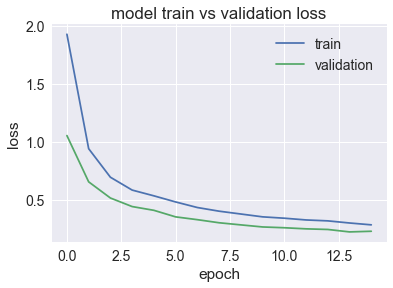

In [264]:
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')




pyplot.show()

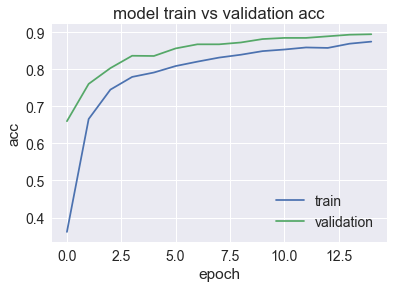

In [265]:

pyplot.plot(history.history['acc'])
pyplot.plot(history.history['val_acc'])
pyplot.title('model train vs validation acc')
pyplot.ylabel('acc')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='lower right')
pyplot.show()

## Test

In [266]:
df = pd.read_csv('l_h_test_sk.csv',header=None )
np.random.seed(42)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,300
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,3.0,1.0,136.0,1.0,5.339931,Aria
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,3.0,1.0,64.0,1.0,3.772055,Aria
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,3.0,1.0,64.0,1.0,3.772055,Aria
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,3.0,1.0,64.0,1.0,3.772055,Aria
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,3.0,1.0,64.0,1.0,3.772055,Aria


In [267]:
## 
X =df[df.columns[0:-1]]
X=np.array(X)

y=df[df.columns[-1]]  

scaler = Normalizer().fit(X)
X = scaler.transform(X)
# summarize transformed data



from sklearn import preprocessing 
le = preprocessing.LabelEncoder()
y=le.fit_transform(y)



from keras.utils import np_utils
y = np_utils.to_categorical(y)


# reshape input to be [samples, time steps, features]
X_test = np.reshape(X, (X.shape[0], 1, X.shape[1]))



# reshape input to be [samples, time steps, features]
Y_test = np.reshape(y, (y.shape[0],  y.shape[1]))


In [268]:
Y_test

array([[1.00, 0.00, 0.00, ..., 0.00, 0.00, 0.00],
       [1.00, 0.00, 0.00, ..., 0.00, 0.00, 0.00],
       [1.00, 0.00, 0.00, ..., 0.00, 0.00, 0.00],
       ...,
       [0.00, 0.00, 0.00, ..., 0.00, 0.00, 1.00],
       [0.00, 0.00, 0.00, ..., 0.00, 0.00, 1.00],
       [0.00, 0.00, 0.00, ..., 0.00, 0.00, 1.00]])

## TEST DEĞERLENDİRME

In [269]:
loss,acc = model.evaluate(X_test,Y_test,batch_size=Batch_size)
print("Loss for testing = {} and Accuracy for testing = {}".format(loss,acc))
predicted = model.predict(X_test)

1350/1350 [==============================] - 0s 157us/step
Loss for testing = 1.6770667310192948 and Accuracy for testing = 0.640000002251731


In [270]:
(predicted.shape)

(1350, 27)

In [271]:
#predicted = model.predict(X_test)

In [272]:
(predicted.shape)

(1350, 27)

### grafik mırafik

In [273]:
def compute_metrics(predicted, Y_test):   
    Y_classes = [np.argmax(item) for item in Y_test]
    #print(Y_classes)
    predicted_classes = [np.argmax(item) for item in predicted]
    predictions = np.array(predicted_classes)
    Y_actual = np.array(Y_classes)
   
    y_actu = pd.Series(np.reshape(Y_actual,len(Y_actual)), name='Actual')
    y_pred = pd.Series(np.reshape(predictions, len(predictions)), name='Predicted')
    
    y_act = pd.Categorical(y_actu, categories=list(range(0,27)))
    y_pre = pd.Categorical(y_pred, categories=list(range(0,27)))
    
    #F1 score
    from sklearn.metrics import f1_score
    print("Average F1 score is {}".format(f1_score(Y_classes, predicted_classes, average='weighted', labels = list(range(0,27)))))
    
    df_confusion = pd.crosstab(y_act, y_pre, rownames =['Actual'],colnames=['Predicted'])
    print("Confusion matrix: \n", df_confusion)
    #pprint.pprint(df_confusion)
    
    predicted= np.array(predicted).tolist()
    Y_test = np.array(Y_test).tolist()

    n_classes = 27
    print("n_classes is: ", n_classes)
    Y_test= np.asarray(Y_test)
    predicted = np.asarray(predicted)
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], predicted[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), predicted.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    lw = 2
    # Compute macro-average ROC curve and ROC area
    #First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()
    return df_confusion

In [274]:
predicted

array([[0.00, 0.00, 0.00, ..., 0.97, 0.00, 0.00],
       [1.00, 0.00, 0.00, ..., 0.00, 0.00, 0.00],
       [1.00, 0.00, 0.00, ..., 0.00, 0.00, 0.00],
       ...,
       [0.00, 0.00, 0.00, ..., 0.00, 0.00, 1.00],
       [0.00, 0.00, 0.00, ..., 0.00, 0.00, 1.00],
       [0.00, 0.00, 0.00, ..., 0.00, 0.00, 1.00]], dtype=float32)

In [275]:
print(predicted.shape, Y_test.shape)

(1350, 27) (1350, 27)


c:\users\kahraman\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Average F1 score is 0.6361637204534725
Confusion matrix: 
 Predicted  0   1   2   3   4   5   6   7   8   9   ...  16  18  19  20  21  \
Actual                                             ...                       
0          41   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
1           0  36   0   0   0   0   0   0   0   6  ...   0   0   0   0   0   
2           0   7  35   0   0   8   0   0   0   0  ...   0   0   0   0   0   
3           0   0   0  32   0   0   0   0   0   0  ...   0   0   0   0   0   
4           0   0   0   0  34   0   0   0   0   0  ...   0   0   0   0   0   
5           0   0   0   0   0  16  20   0   6   0  ...   0   0   0   0   0   
6           0   0   0   0   0   0  13   0  37   0  ...   0   0   0   0   0   
7           0   0   0   0   0   0   0  20  16   0  ...   0   0   0   0   0   
8           0   0   0   0   0   6  33   0  11   0  ...   0   0   0   0   0   
9           0   0   0   0   0   0   0   0  11  39  ...   0   0   0   0   0   
10   

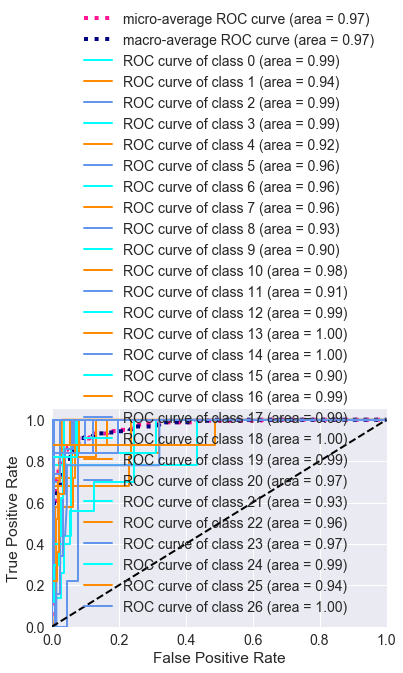

In [276]:
df=compute_metrics(predicted, Y_test)

In [277]:
matrix = metrics.confusion_matrix(Y_test.argmax(axis=1), predicted.argmax(axis=1))

In [278]:
cm=matrix

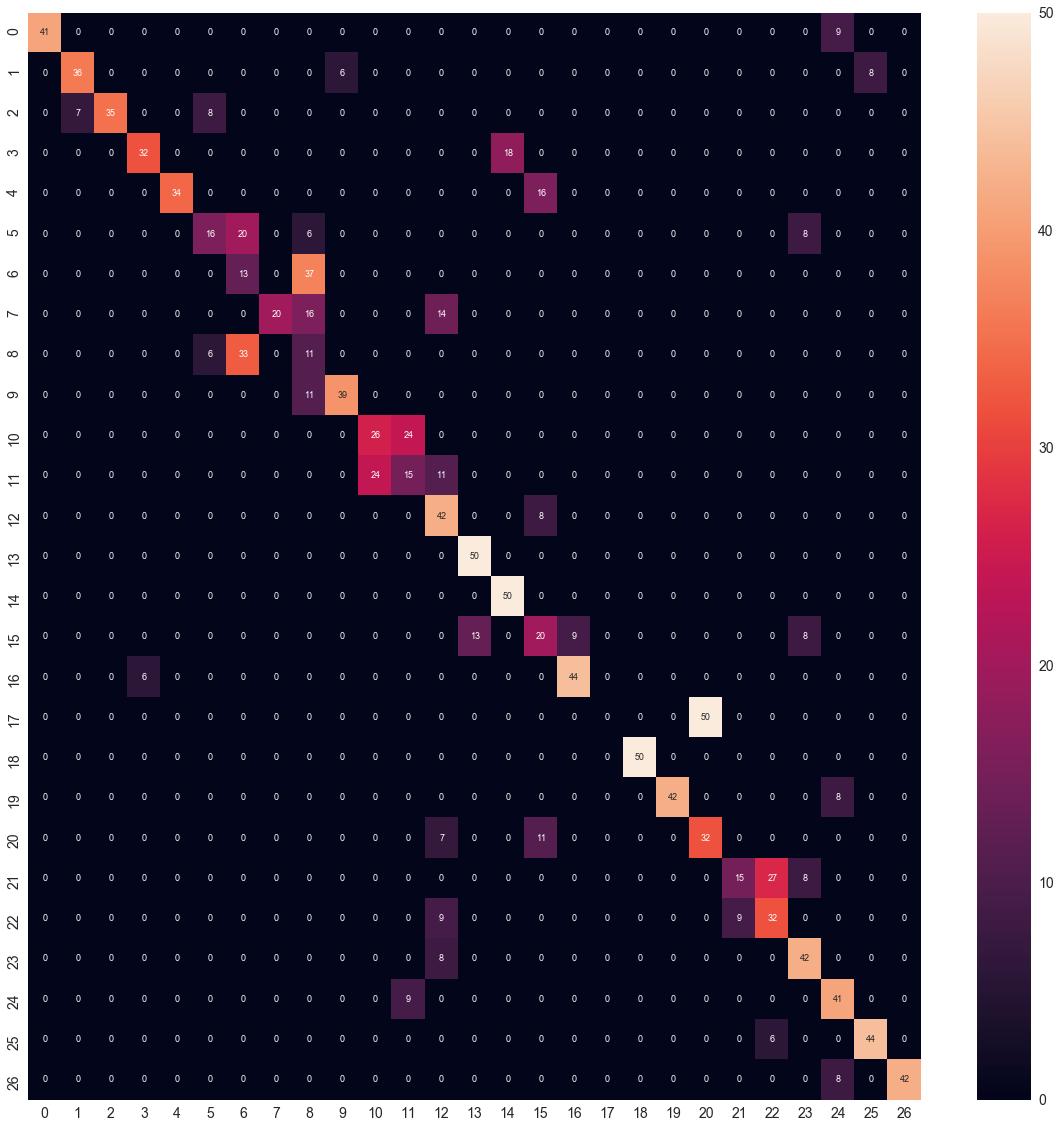

In [279]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt



df_cm = pd.DataFrame(matrix, range(27), range(27))
plt.figure(figsize=(20,20))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 9}) # font size

plt.show()

 ## blove part taken from https://www.python-course.eu/confusion_matrix.php

In [280]:
def precision(label, confusion_matrix):
    col = confusion_matrix[:, label]
    return confusion_matrix[label, label] / col.sum()
    
def recall(label, confusion_matrix):
    row = confusion_matrix[label, :]
    return confusion_matrix[label, label] / row.sum()

def precision_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_precisions = 0
    for label in range(rows):
        sum_of_precisions += precision(label, confusion_matrix)
    return sum_of_precisions / rows

def recall_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_recalls = 0
    for label in range(columns):
        sum_of_recalls += recall(label, confusion_matrix)
    return sum_of_recalls / columns

print("label precision recall fscore")
for label in range(27):
    pr=precision(label, cm)
    rec=recall(label, cm)
    f1=2*(pr*rec/(pr+rec))
    print(f"{label:5d} {pr:9.3f} {rec:6.3f} {f1:6.3f}")

label precision recall fscore
    0     1.000  0.820  0.901
    1     0.837  0.720  0.774
    2     1.000  0.700  0.824
    3     0.842  0.640  0.727
    4     1.000  0.680  0.810
    5     0.533  0.320  0.400
    6     0.197  0.260  0.224
    7     1.000  0.400  0.571
    8     0.136  0.220  0.168
    9     0.867  0.780  0.821
   10     0.520  0.520  0.520
   11     0.312  0.300  0.306
   12     0.462  0.840  0.596
   13     0.794  1.000  0.885
   14     0.735  1.000  0.847
   15     0.364  0.400  0.381
   16     0.830  0.880  0.854
   17       nan  0.000    nan
   18     1.000  1.000  1.000
   19     1.000  0.840  0.913
   20     0.390  0.640  0.485
   21     0.625  0.300  0.405
   22     0.492  0.640  0.557
   23     0.636  0.840  0.724
   24     0.621  0.820  0.707
   25     0.846  0.880  0.863
   26     1.000  0.840  0.913


c:\users\kahraman\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in longlong_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


In [281]:
def accuracy(confusion_matrix):
    diagonal_sum = confusion_matrix.trace()
    sum_of_all_elements = confusion_matrix.sum()
    return diagonal_sum / sum_of_all_elements 
accuracy(cm)

0.64

## MODEL SAVING RELOADING

In [282]:
from keras.models import load_model
model.save(model_FileName)  # creates a HDF5 file 'my_model.h5'



In [283]:

# returns a compiled model
# identical to the previous one
model = load_model('54.h5')

In [284]:
len(predicted)

1350

In [285]:
float_formatter = "{:.2f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

In [286]:


ths =open( "y_and_p_compare.csv", "w")


counter=-1
for i in range (len(predicted)):
    float_formatter = "{:.2f}".format
    print(Y_test[i],predicted[i])
    
    y= str(counter)+"-"+str(i)+"-            "+str(Y_test[i])
    y=y.replace("\n","")
    y=y+"\n"
    p=  str(counter)+"-"+str(i)+"-            "+str(predicted[i])
    p=p.replace("\n","")
    p=p+"\n"
    ths.write(y)
    ths.write(p)
    ths.write("\n")
    
    if i%50==0:
        counter=counter+1
        print(counter)
ths.close()        

[1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00] [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.03 0.00 0.00
 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.97 0.00 0.00]
0
[1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00] [1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00]
[1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00] [1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00]
[1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00] [1.00 0.00 0.00 0.00 0.00 0.00 0

[0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00
 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00] [0.00 0.00 0.00 0.00 0.00 0.05 0.07 0.00 0.32 0.00 0.00 0.00 0.53 0.00
 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.02 0.00 0.00 0.00]
[0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00
 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00] [0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00
 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00]
[0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00
 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00] [0.00 0.00 0.00 0.00 0.00 0.02 0.16 0.03 0.80 0.00 0.00 0.00 0.00 0.00
 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00]
[0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00
 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00] [0.00 0.00 0.00 0.00 0.00 0.02 0.1

 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00]
[0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00
 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00] [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00
 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00]
[0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00
 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00] [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00
 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00]
[0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00] [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00]
14
[0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
 1.00 0.00 0.00 0.00 0.00 0.00 

 0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00] [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00]
[0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
 0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00] [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.82 0.18 0.00 0.00 0.00 0.00]
[0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
 0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00] [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.21 0.79 0.00 0.00 0.00 0.00]
[0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
 0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00] [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
 0.00 0.00 0.00 0.00 0.00 0.00 0.0